**Import relevant packages**

In [27]:
import json
import csv
from pprint import pprint
import pandas as pd
import seaborn as sns
import math
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import os
from math import log as ln

**Some methods that will be used everywhere **

In [28]:
#All the soccer playing nations in the dataset
L_countries = {}
nations_path = '../data/Nations.txt'
with open(nations_path) as nations_file:
	for nation in nations_file:
		L_countries[nation.replace('\n','')] = 0
        
#Common methods to be used across multiple scripts
'''
Source code from https://github.com/oliviaguest/gini
'''
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

def sdi(data):        
    N = sum(data.values())

    def p(n, N):
        """ Relative abundance """
        if n is  0:
            return 0
        else:
            return (float(n)/N) * ln(float(n)/N)
    
    return -sum(p(n, N) for n in data.values() if n is not 0)

def minutes_parser(minutes_string):
    if minutes_string == '-':
        return 0
    return int(minutes_string.replace('\'','').replace('.',''))

def csv_writer(params, values_lists, path):
    with open(path, "w") as csv_file:
        writer = csv.writer(csv_file, delimiter=',')
              
        writer.writerow(params)
        
        for line in values_lists:
            writer.writerow(line)
            
def csv_dict_reader(file_obj):
    reader = csv.DictReader(file_obj, delimiter=',')
    for line in reader:
        print(line["Name"])
        #print(line["Matches"])

def csv_reader(file_obj):
    reader = csv.reader(file_obj)
    for row in reader:
        print(" ".join(row))

#the heatmap to plot from dataframe 'df'
def plot(df):
    corr = df.corr()
    sns.set(font_scale=0.8)
    sns.heatmap(corr, cmap="YlGnBu", annot=True, annot_kws={"size": 13})
    sns.plt.yticks(rotation=0)
    sns.plt.xticks(rotation=90) 
    sns.plt.show()

def plot_time_series(df, title, y_top):
    #plot graph
    ax = df.plot(figsize=(12,8),marker='o')
       
    #set title
    plt.title(title, fontsize=13)
    
    #set ticks roatation
    plt.xticks(rotation=50)
    ax.set_ylabel('Percentages')
       
    ax.set_ylim(top=y_top)
    ax.set_ylim(bottom=0)

    plt.show()

## 1. Comparing percentage of playing time given to foreign players in each league

In [29]:
def get_league_comparison_df():
	years = [str(year) for year in range(1995, 2017)]
	countries = ['England', 'France', 'Germany', 'Italy', 'Spain']
	L_all_data = []

	for country in countries:
		data_file = data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'

		L_local = []
		L_foreign = []

		L_local_minutes = []
		L_foreign_minutes = []

		L_local_apps = []
		L_foreign_apps = []

		with open(data_file) as datafile:
			data = json.load(datafile)
			for year in years:
				local = 0
				foreign = 0
				local_minutes = 0
				foreign_minutes = 0
				local_apps = 0
				foreign_apps = 0

				#data for a particular year
				league_year_data = data[year]
				#go trhough each team in the year
				for team in league_year_data:
					year_data = data[year][team]

					for key in year_data:
						player = year_data[key]
						player_country = player['nationality']
						if(player_country == country):
							local += 1
							local_minutes += minutes_parser(player['minutes'])
							local_apps += player['appearances']
						else:
							foreign += 1
							foreign_minutes += minutes_parser(player['minutes'])
							foreign_apps += player['appearances']

				total = local + foreign
				L_local.append((local/total)*100)
				L_foreign.append((foreign/total)*100)

				total = local_apps + foreign_apps
				L_local_apps.append((local_apps/total) * 100)
				L_foreign_apps.append((foreign_apps/total) * 100)

				total = local_minutes + foreign_minutes
				L_local_minutes.append((local_minutes/total)*100)
				L_foreign_minutes.append((foreign_minutes/total)*100)

			L_all_data.append(L_foreign_minutes)


	df = pd.DataFrame({'England': L_all_data[0],
						'France': L_all_data[1],
						'Germany': L_all_data[2],
						'Italy' : L_all_data[3],
						'Spain' : L_all_data[4],
						'Year': years			})
	df = df.set_index('Year')
	return df

        England     France    Germany      Italy      Spain
Year                                                       
1995  36.391551  20.076871  23.545465  19.118457  21.096770
1996  44.389853  27.630522  28.983765  25.135736  35.178378
1997  48.640584  26.143216  36.123795  27.975180  42.478662
1998  52.518440  28.061479  41.135187  31.741860  43.113172
1999  55.197259  29.639085  42.594335  32.783777  40.834220
2000  55.140512  33.377798  49.620621  35.506366  37.578903
2001  58.561312  38.344064  52.267888  32.203117  34.787820
2002  61.951640  41.634428  58.677507  31.831739  34.139652
2003  63.276169  43.473815  57.181072  32.183689  38.339908
2004  62.238905  48.217958  54.699211  28.895867  33.624242
2005  62.235778  48.576804  54.168397  30.038399  36.577624
2006  61.291384  46.571375  55.300211  26.364379  39.117465
2007  65.018765  44.526110  56.506061  32.578788  39.653607
2008  63.191627  46.055635  58.543315  38.102057  36.898817
2009  65.831715  49.432226  57.502628  4

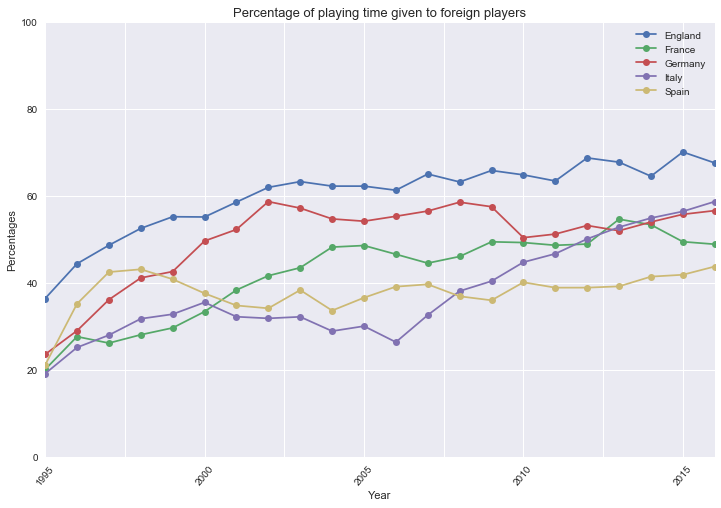

In [30]:
df = get_league_comparison_df()
pprint(df)
plot_time_series(df, 'Percentage of playing time given to foreign players',100)

**Written analysis about the above graph**

## 2. Comparing percentage of players of certain nationalities in the top 5 soccer leagues

In [31]:
def get_nationalities_df():
	years = [str(year) for year in range(1995, 2017)]
	countries = ['England', 'France', 'Germany', 'Italy', 'Spain']

	final_data = []

	for country in countries:
		final_data.append([])
		for year in years:
			final_data[-1].append(0)

	for year in years:
		total = 0

		for country in countries:
			data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'

			with open(data_file) as datafile:
				data = json.load(datafile)

				#data for a particular year
				league_year_data = data[year]
				#go trhough each team in the year
				for team in league_year_data:
					year_data = data[year][team]
					#each player
					for key in year_data:
						player = year_data[key]
						player_country = player['nationality']
						if player_country in countries:
							final_data[countries.index(player_country)][int(year) - 1995] += 1
						total += 1

		for country in countries:
			final_data[countries.index(country)][int(year) - 1995] /= total
			final_data[countries.index(country)][int(year) - 1995] *= 100

	L_all_data = final_data

	df = pd.DataFrame({'English': L_all_data[0],
						'French': L_all_data[1],
						'German': L_all_data[2],
						'Italian' : L_all_data[3],
						'Spanish' : L_all_data[4],
						'Year': years			})
	df = df.set_index('Year')
	return df

        English     French     German    Italian    Spanish
Year                                                       
1995  13.954358  16.647961  14.141414  15.488215  16.049383
1996  12.680014  15.033368  14.014752  15.700738  15.033368
1997  12.052796  14.379993  12.400139  15.977770  12.678013
1998  11.282579  15.157750  12.174211  15.226337  11.522634
1999  10.896130  14.528174  11.812627  14.562118  12.457570
2000   9.772727  13.084416  11.233766  15.876623  12.012987
2001   8.794137  14.890073  10.426382  14.223851  12.491672
2002   8.629776  14.657444   9.617918  13.735178  14.196311
2003   8.314461  13.717244   9.576189  14.234875  14.137819
2004   7.960039  12.665163   9.216887  16.016758  15.178859
2005   7.492795  12.872238  10.246558  16.266411  13.320525
2006   8.333333  11.842105   9.461153  16.384712  13.063910
2007   7.997539  11.934789   9.412488  14.241772  12.796063
2008   8.478261  12.267081   8.664596  13.913043  13.012422
2009   8.646392  11.598092   8.944544  1

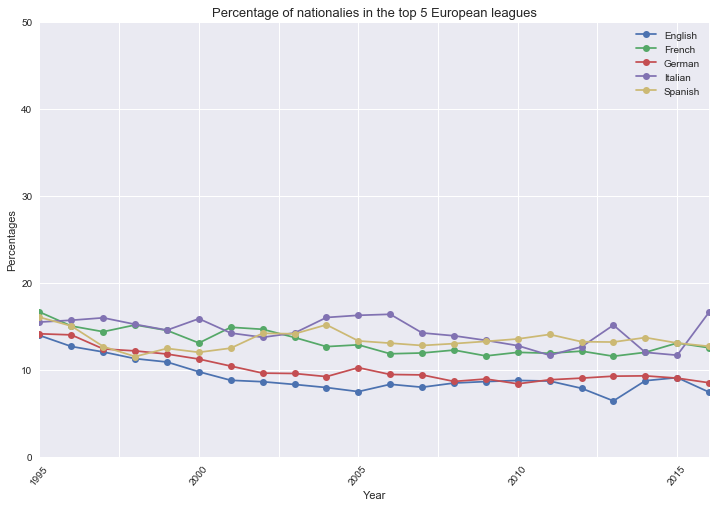

In [32]:
df = get_nationalities_df()
pprint(df)
plot_time_series(df, 'Percentage of nationalies in the top 5 European leagues',50)

## 3. Correlation between diversity, foreign playing time percentage and winning

### 3.1. Correlation in different leagues

In [33]:
def get_team_percentage(country, data, year, team):
	age = 0
	local = 0
	foreign = 0
	local_minutes = 0
	foreign_minutes = 0
	local_apps = 0
	foreign_apps = 0

	for nation in L_countries:
			L_countries[nation] = 0 

	
	year_data = data[year][team]

	for key in year_data:
		player = year_data[key]
		player_country = player['nationality']
		if(player_country == country):
			local += 1
			local_minutes += minutes_parser(player['minutes'])
			local_apps += player['appearances']
		else:
			foreign += 1
			foreign_minutes += minutes_parser(player['minutes'])
			foreign_apps += player['appearances']
		age += (player['age'] * minutes_parser(player['minutes']))
		#increase the country count
		if player_country != 'N/A':
			L_countries[player_country] = L_countries[player_country] + player['appearances']
	

	#gini_value = gini(np.asarray(list(L_countries.values()), dtype=np.float))
	diversity = sdi(L_countries)
	average_age = age/(local + foreign)
	total = local_minutes + foreign_minutes
	return [(foreign_minutes/total)*100, average_age, diversity]

In [34]:
def get_country_correlations(country):
	years = [year for year in range(1995, 2017)]

	rows = []
	params = ['Won', 'Lost', 'Draw', 'GF', 'GA',  'PPM', 'Foreign playing minutes %', 'Average age', 'diversity']

	data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'

	for year in years:
		path = '../data/Standings/' + country + '/' + str(year) + '.csv'

		with open(path, "r") as file_obj:
			reader = csv.DictReader(file_obj, delimiter=',')

			with open(data_file) as datafile:
				data = json.load(datafile)
				for line in reader:
					#new row data for each team
					row = []

					team_name = line['Name']
					won_matches = int(line['Won'])
					lost_matches = int(line['Lost'])
					draw_matches = int(line['Draw'])
					total_matches = won_matches + lost_matches + draw_matches
					row.append(won_matches/total_matches)
					row.append(lost_matches/total_matches)
					row.append(draw_matches/total_matches)
					row.append(int(line['GF']))
					row.append(int(line['GA']))
					row.append(float(line['PPM']))

					vals = get_team_percentage(country, data, str(year), team_name)

					row.append(vals[0])
					row.append(vals[1])
					row.append(vals[2])

					rows.append(row)

	csv_writer(params, rows, 'out.csv')
	df = pd.read_csv('out.csv')  
	os.remove('out.csv')
	#print(len(df.index))    
	return df

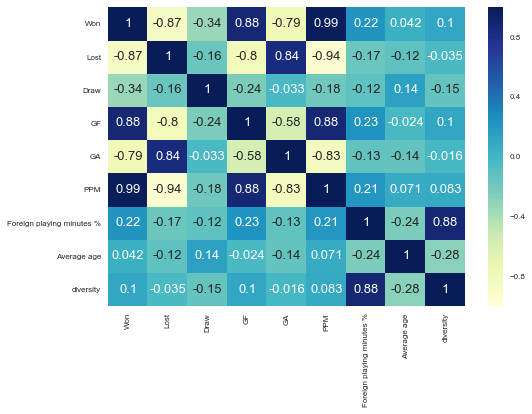

In [35]:
df = get_country_correlations('England')
plot(df)

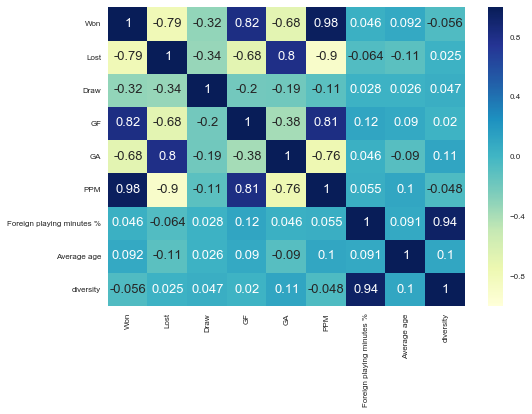

In [36]:
df = get_country_correlations('France')
plot(df)

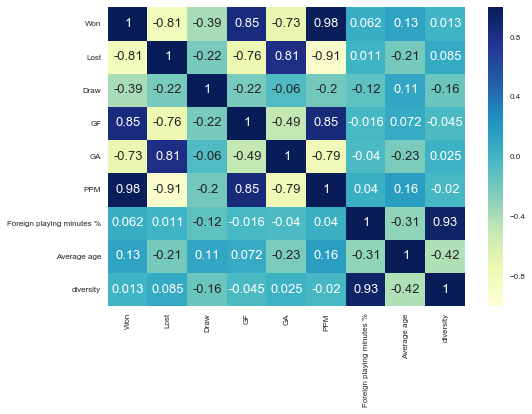

In [37]:
df = get_country_correlations('Germany')
plot(df)

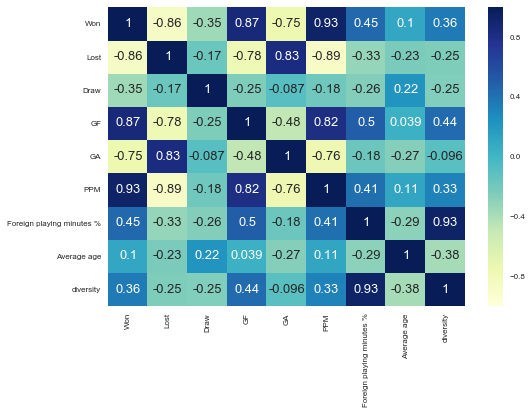

In [38]:
df = get_country_correlations('Italy')
plot(df)

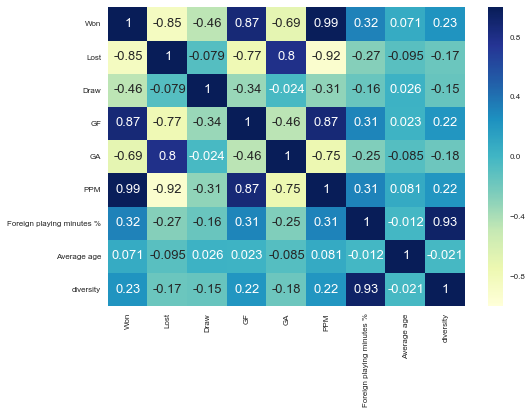

In [39]:
df = get_country_correlations('Spain')
plot(df)

### 3.2 Correlation across all leagues

In [40]:
def get_combined_correlations():
	years = [year for year in range(1995, 2017)]
	params = ['Won', 'Lost', 'Draw', 'GF', 'GA',  'PPM', 'Foreign playing minutes %', 'Average age', 'diversity']
	countries = ['England', 'France', 'Germany', 'Italy', 'Spain']
	rows = []

	for country in countries:
		data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'

		for year in years:
			path = '../data/Standings/' + country + '/' + str(year) + '.csv'

			with open(path, "r") as file_obj:
				reader = csv.DictReader(file_obj, delimiter=',')

				with open(data_file) as datafile:
					data = json.load(datafile)
					for line in reader:

						#new row data for each team
						row = []
						team_name = line['Name']
						# pprint(team_name + ':  ' + str(get_team_percentage(data, '2001', team_name)))
						# pprint(line)
						won_matches = int(line['Won'])
						lost_matches = int(line['Lost'])
						draw_matches = int(line['Draw'])
						total_matches = won_matches + lost_matches + draw_matches
						row.append(won_matches/total_matches)
						row.append(lost_matches/total_matches)
						row.append(draw_matches/total_matches)
						row.append(int(line['GF']))
						row.append(int(line['GA']))
						#row.append(int(line['Points']))
						row.append(float(line['PPM']))
						vals = get_team_percentage(country, data, str(year), team_name)

						row.append(vals[0])
						row.append(vals[1])
						row.append(vals[2])

						rows.append(row)
	csv_writer(params, rows, 'out.csv')

	df = pd.read_csv('out.csv')
	os.remove('out.csv')   
	return df 

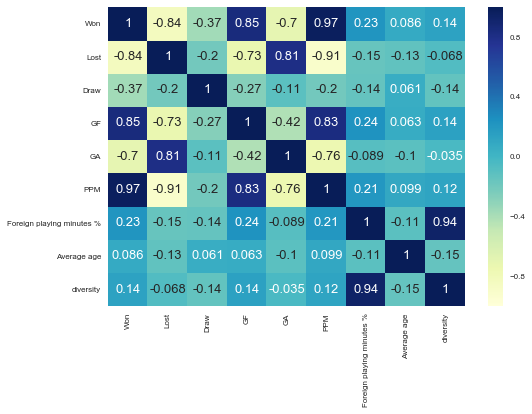

In [41]:
df = get_combined_correlations()
plot(df)

## 4. Interesting cases

In [42]:
def get_team_percentages_df(country, team):
	data_file = '../data/Leistungsdaten/' + str(country) + '/2016.json'
	years = [str(year) for year in range(1995, 2017)]

	L_local = []
	L_foreign = []

	L_local_minutes = []
	L_foreign_minutes = []

	L_local_apps = []
	L_foreign_apps = []



	years_copy = [str(year) for year in range(1995, 2017)]

	with open(data_file) as datafile:
		data = json.load(datafile)
		for year in years:
			local = 0
			foreign = 0
			local_minutes = 0
			foreign_minutes = 0
			local_apps = 0
			foreign_apps = 0
			L_countries = {}
			#data for a particular year
			try:
				year_data = data[year][team]

				for key in year_data:
					player = year_data[key]
					player_country = player['nationality']
					if(player_country == country):
						local += 1
						local_minutes += minutes_parser(player['minutes'])
						local_apps += player['appearances']
					else:
						foreign += 1
						foreign_minutes += minutes_parser(player['minutes'])
						foreign_apps += player['appearances']
					if player_country not in L_countries.keys():
						L_countries[player_country] = 0
					L_countries[player_country] = L_countries[player_country] + 1

				total = local + foreign
				L_local.append((local/total)*100)
				L_foreign.append((foreign/total)*100)

				total = local_apps + foreign_apps
				L_local_apps.append((local_apps/total) * 100)
				L_foreign_apps.append((foreign_apps/total) * 100)

				total = local_minutes + foreign_minutes
				L_local_minutes.append((local_minutes/total)*100)
				L_foreign_minutes.append((foreign_minutes/total)*100)
			except:
				years_copy.remove(year)
				pass
			#pprint(L_countries)

	df = pd.DataFrame({
						'Foreign players': L_foreign,
						'Foreign minutes': L_foreign_minutes,
						'Foreign appearances': L_foreign_apps,
						'Year': years_copy			})
	df = df.set_index('Year')
	return df

      Foreign appearances  Foreign minutes  Foreign players
Year                                                       
1995             0.000000         0.000000         0.000000
1996             2.768166         2.949302         3.448276
1997             0.000000         0.000000         0.000000
1998             0.000000         0.000000         0.000000
1999             0.000000         0.000000         0.000000
2000             0.000000         0.000000         0.000000
2001             0.000000         0.000000         0.000000
2002             0.000000         0.000000         0.000000
2003             0.000000         0.000000         0.000000
2004             0.000000         0.000000         0.000000
2005             2.851711         2.953586         2.500000
2006             5.113636         4.754265         3.333333
2007             6.390977         7.928552         3.125000
2008             5.471698         6.638982         3.125000
2009             6.403013         7.9157

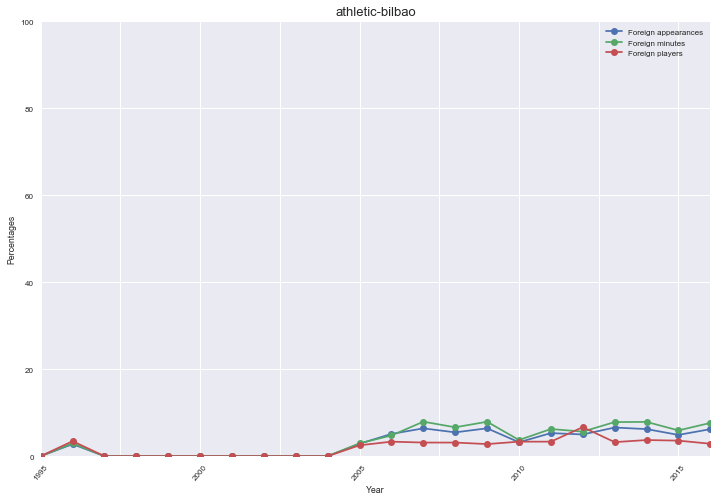

In [43]:
country = 'Spain'
team = 'athletic-bilbao'
df = get_team_percentages_df(country, team)
pprint(df)
plot_time_series(df, team, 100)

      Foreign appearances  Foreign minutes  Foreign players
Year                                                       
1995            18.965517        16.631397        25.000000
1996            28.510638        25.956600        35.294118
1997            34.497817        34.063383        37.500000
1998            41.452991        38.410715        36.363636
1999            41.594828        38.716695        43.333333
2000            43.487859        41.326713        40.000000
2001            52.991453        52.029675        43.750000
2002            47.751606        46.443365        43.750000
2003            52.277657        56.088241        51.428571
2004            49.658314        51.127238        50.000000
2005            46.799117        47.257158        40.000000
2006            55.097614        52.043004        43.750000
2007            64.102564        62.916257        50.000000
2008            68.000000        65.750297        63.157895
2009            57.082452        55.6235

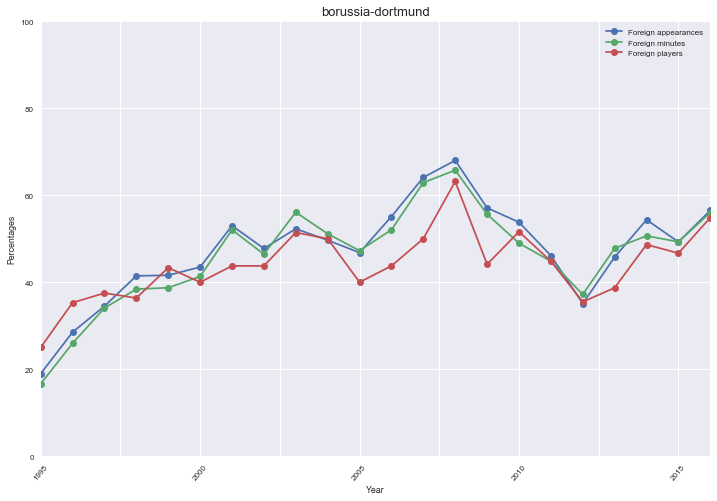

In [44]:
country = 'Germany'
team = 'borussia-dortmund'
df = get_team_percentages_df(country, team)
pprint(df)
plot_time_series(df, team, 100)

      Foreign appearances  Foreign minutes  Foreign players
Year                                                       
1995            24.890830        21.704146        26.666667
1996            24.637681        21.780506        31.250000
1997            45.129225        43.096379        43.333333
1998            53.984064        49.490873        52.777778
1999            66.011788        62.776193        57.142857
2000            67.330677        63.961203        66.666667
2001            62.840467        60.069547        55.555556
2002            68.511450        66.173367        67.741935
2003            79.724409        79.155785        71.875000
2004            88.514851        87.291450        87.500000
2005            93.604651        92.696166        84.848485
2006            96.887160        98.292741        85.714286
2007            94.961240        96.648179        87.500000
2008            93.762183        95.149124        78.947368
2009            91.809524        93.2474

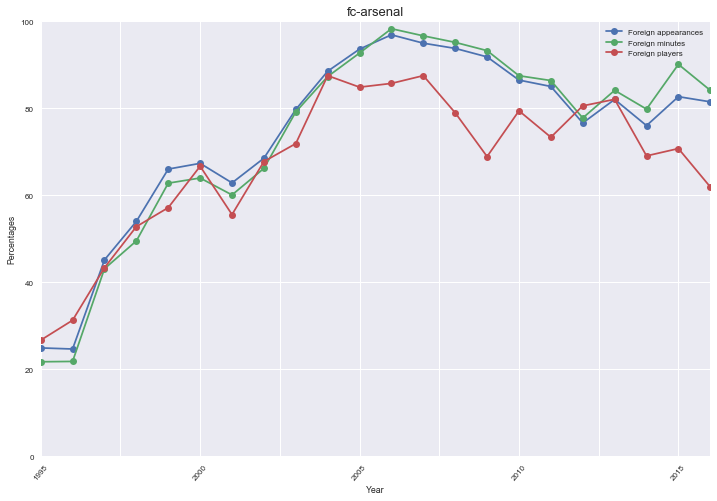

In [45]:
country = 'England'
team = 'fc-arsenal'
df = get_team_percentages_df(country, team)
pprint(df)
plot_time_series(df, team, 100)

      Foreign appearances  Foreign minutes  Foreign players
Year                                                       
1995            20.562390        19.292917        20.689655
1996            48.021583        53.526549        38.461538
1997            43.713733        46.483335        39.285714
1998            56.420233        58.523000        48.148148
1999            47.297297        46.265254        45.454545
2000            38.728324        39.019435        37.931034
2001            38.684720        38.001865        36.666667
2002            48.176583        48.420912        36.000000
2003            42.857143        43.583710        25.925926
2004            51.233397        52.754711        31.250000
2005            54.263566        52.885849        50.000000
2006            51.744186        52.227228        39.473684
2007            67.547170        63.119619        68.000000
2008            65.530303        65.194847        54.285714
2009            51.228733        49.3960

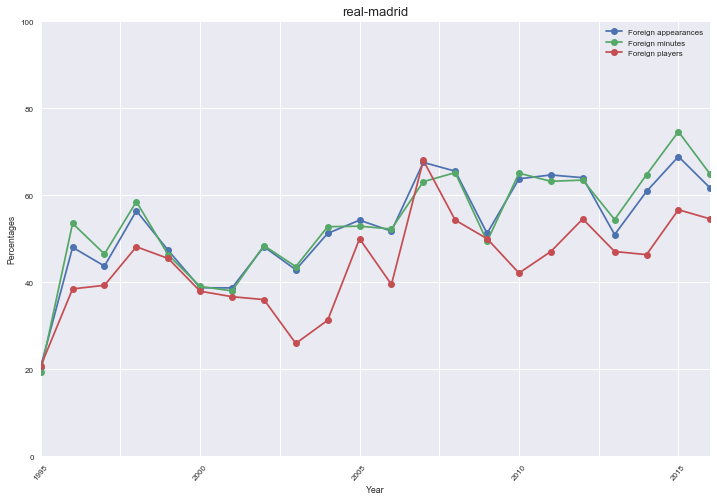

In [46]:
country = 'Spain'
team = 'real-madrid'
df = get_team_percentages_df(country, team)
pprint(df)
plot_time_series(df, team, 100)